# Code for photon simulation and energy deposition distribution in tissue considering PE, CS and  PP
---
### This code is adjusted for 2D model of tissue
 - original code is part of buildup calculation simulation of photons propagating thorugh lead shiled, [link](https://github.com/MateHudo/PhotonPropagationMCSimulation/tree/master)
 - link to [GitHub repo](https://github.com/MateHudo/TumorIrradiationModel) for the Tumor Irradiation project
 - code is not adjusted fully for 2D simulation, but works, for proper code needs some further fixing!


In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
import datetime
from datetime import datetime as dt

import scienceplots
plt.style.use(['science','notebook','grid'])


import os
print(os.getcwd())
import sys



c:\FAKS\MAGISTERIJ\MODELSKA_ANALIZA_1\MA1 naloge\MA-ZaključnaNaloga\main\code\PPS_photon_propagation_simulation


---
---
# 1. Calculate LAC from NIST XCOM database
 - for mixture, elemental composition is important, must take **weight fractions** (and not relative abundancies!)

In [2]:
"""
### SOFT TISSUE COMPOSITION (elements by weight and abundance fractions): 
 - Element 	  Weight %	  Atomic %	Notes
 - O       	      61.0	      25.5	Water, organic molecules
 - C       	      23.0	       9.5	Organic structures
 - H       	      10.2	      63.0	Water, hydrocarbons
 - N       	       2.6	       1.4	Proteins, DNA
 - Ca      	       1.4	      0.22	Bones, signaling
 - P       	       1.1	      0.22	DNA, bones (phosphate)
 - K       	       0.2	      0.03	Electrolyte
 - S       	       0.2	     0.038	Proteins (cysteine, methionine)
 - Na      	      0.14	      0.02	Electrolyte
 - Cl      	      0.12	      0.02	Electrolyte
 - Mg      	     0.027	     0.003	Enzymes, bones
 - Fe      	     0.006	    0.0001	Hemoglobin
 - Zn      	     0.003	     4e-05	Enzymes
 - Cu      	    0.0001	     1e-05	Trace metal
 - I       	   1.6e-05	     1e-06	Thyroid hormone
 - Se      	   1.9e-05	     1e-06  Antioxidans
"""

'\n### SOFT TISSUE COMPOSITION (elements by weight and abundance fractions): \n - Element \t  Weight %\t  Atomic %\tNotes\n - O       \t      61.0\t      25.5\tWater, organic molecules\n - C       \t      23.0\t       9.5\tOrganic structures\n - H       \t      10.2\t      63.0\tWater, hydrocarbons\n - N       \t       2.6\t       1.4\tProteins, DNA\n - Ca      \t       1.4\t      0.22\tBones, signaling\n - P       \t       1.1\t      0.22\tDNA, bones (phosphate)\n - K       \t       0.2\t      0.03\tElectrolyte\n - S       \t       0.2\t     0.038\tProteins (cysteine, methionine)\n - Na      \t      0.14\t      0.02\tElectrolyte\n - Cl      \t      0.12\t      0.02\tElectrolyte\n - Mg      \t     0.027\t     0.003\tEnzymes, bones\n - Fe      \t     0.006\t    0.0001\tHemoglobin\n - Zn      \t     0.003\t     4e-05\tEnzymes\n - Cu      \t    0.0001\t     1e-05\tTrace metal\n - I       \t   1.6e-05\t     1e-06\tThyroid hormone\n - Se      \t   1.9e-05\t     1e-06  Antioxidans\n'

In [112]:
import importlib
from src import LinearAttenuationCoefficients
from src import BoxPropagationSimulator2D as Simulator
from src import gps
from src import * #? not working as wished?

-----------------------------Material: Soft Tissue----------------------------------



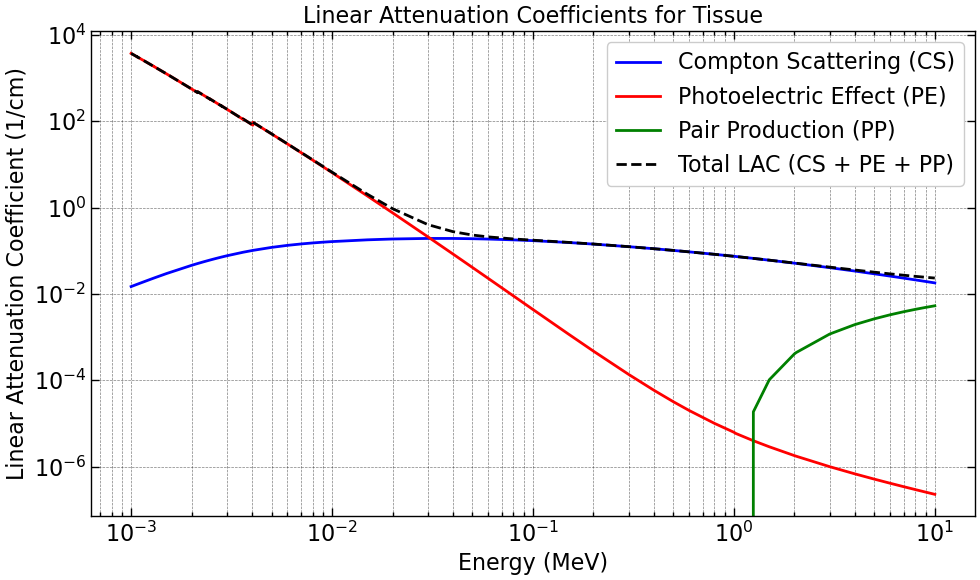

In [113]:
importlib.reload(LinearAttenuationCoefficients)

path = "../mac_nistxcom/mac_tissue.txt"
tissue_density = 1.06  # g/cm^3

tissue_lac_importer = LinearAttenuationCoefficients.LACLoader(path, tissue_density, material_name="Tissue")

energy_tissue, lac_pp_tissue, lac_cs_tissue, lac_pe_tissue, lac_total_tissue = tissue_lac_importer.get_lac_data()

#* gather lac data for simulation
LAC_data_tissue = {
    'energy': energy_tissue,  # Energy values for the linear attenuation coefficients
    'lac_cs': lac_cs_tissue,  # Linear attenuation coefficient for Compton scattering 
    'lac_pe': lac_pe_tissue,  # Linear attenuation coefficient for photoelectric effect
    'lac_pp': lac_pp_tissue,  # Linear attenuation coefficient for pair production
}

print("-----------------------------Material: Soft Tissue----------------------------------\n")
tissue_lac_importer.plot()


### check lac_tot for some energies

In [114]:
energies = [0.01,0.05,0.08,0.1,0.5,1.0] # MeV

for energy in energies:
    lac_value = tissue_lac_importer.get_lac_at_energy(energy)
    print(f"At {energy} MeV, total linear attenuation coefficient is {lac_value:.4f} /cm"
          f"; (mean free path = {1/lac_value:.4f} cm)"
          )



At 0.01 MeV, total linear attenuation coefficient is 6.5882 /cm; (mean free path = 0.1518 cm)
At 0.05 MeV, total linear attenuation coefficient is 0.2303 /cm; (mean free path = 4.3426 cm)
At 0.08 MeV, total linear attenuation coefficient is 0.1871 /cm; (mean free path = 5.3437 cm)
At 0.1 MeV, total linear attenuation coefficient is 0.1751 /cm; (mean free path = 5.7106 cm)
At 0.5 MeV, total linear attenuation coefficient is 0.1015 /cm; (mean free path = 9.8537 cm)
At 1.0 MeV, total linear attenuation coefficient is 0.0742 /cm; (mean free path = 13.4798 cm)


---
---
# 2. Define Tissue Dimensions and pixels (2d square box, odd number of pixels in each direction) 

setting up paramters, geometry, photon source, ...

In [115]:
#  we have a square tissue matrix (at least for now)
a = 30.0 #! cm, as lac is in /cm
tissue_length = a  # Length of the cuboid in cm
tissue_width = a  # Width of the cuboid in cm
tissue_dimensions = (tissue_length, tissue_width)

# define number of pixels in the detector
#! CONDITION: box_dimension % num_pixels == 0
num_pixels_x = 11  # Number of pixels along the x direction
num_pixels_y = 11  # Number of pixels along the y direction


pixel_size = (tissue_length / num_pixels_x, tissue_width / num_pixels_y)  # z is not used in 2D
print(f"Detector shape: {tissue_dimensions} cm")
print(f"Number of pixels: {num_pixels_x} x {num_pixels_y}")
print(f"Pixel size: {pixel_size} cm")

Detector shape: (30.0, 30.0) cm
Number of pixels: 11 x 11
Pixel size: (2.727272727272727, 2.727272727272727) cm


---
## 3. Initialize Simulator instance

In [69]:
importlib.reload(Simulator)

simulator = Simulator.box_propagation_simulator2D(
    box_dimensions = tissue_dimensions,
    LAC_data = LAC_data_tissue,
    Emin_terminate = 0.001
)


# 4. Define gps [General Particle Source] template 
* photons are enetring the box on the left side, directed to the right (perpendicular to the left face)
* choose between **monoenergetical** and **rtg model** spectrums

### a) monoenergetical spectrum -> mono_template

In [70]:
importlib.reload(gps)

tissue_shape = {}
tissue_shape["dimensions"] = tissue_dimensions  
tissue_shape["num_pixels"] = (num_pixels_x, num_pixels_y)

#* define monoenergetic photon energy
Emono = 0.08 # MeV

#$ define beam position
print(f"Beam index shall go from 0 to {num_pixels_y - 1} (as we have {num_pixels_y} pixels in y direction)")
print(f"For SITCFs, we need just beams from 0 to {num_pixels_y//2} (last one is central)")
beam_index = 2
print(f"-------------- Beam index: {beam_index} ---------------")

# define pencil beam template for monoenergetic photons
pencil_beam_mono_template = gps.pencil_beam_gps(
    tissue_shape = tissue_shape,
    spectrum_type = "mono",
    Emono = Emono,
)
mono_template = pencil_beam_mono_template.get_gps_template(beam_index=beam_index)
print(f"\nTemplate for monoenergetic beam (index {beam_index}):\n\t {mono_template}")

Beam index shall go from 0 to 10 (as we have 11 pixels in y direction)
For SITCFs, we need just beams from 0 to 5 (last one is central)
-------------- Beam index: 2 ---------------

Template for monoenergetic beam (index 2):
	 {'spectrum_type': 'mono', 'beam_index': 2, 'r': array([-15.        ,   8.18181818,   0.        ]), 'u': array([1, 0, 0]), 'Emono': 0.08}


### a) rtg spectrum -> rtg_template

First define rtg model parameters, visualize

--------------- Is specturm shape realistic??? ----------------------


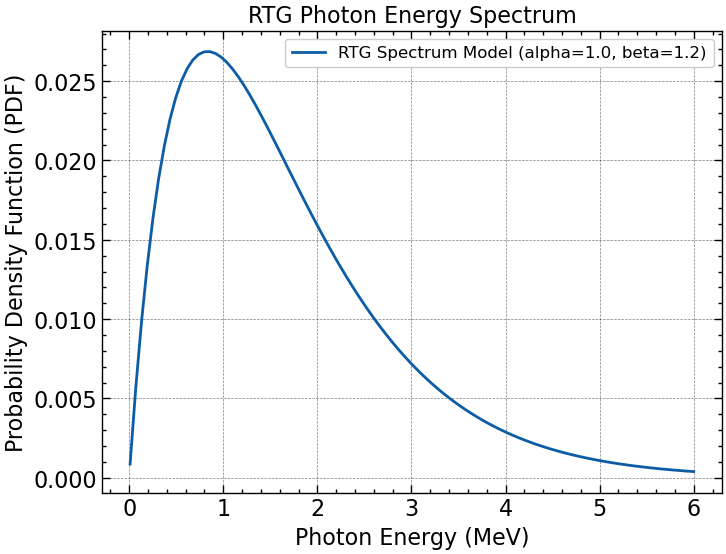

In [71]:
 #$ rtg spectrum model: 
alpha = 1.0  # Power-law exponent for the energy spectrum
beta = 1.2 # Exponential decay factor for the energy spectrum
Emax = 6  # MeV, same a U rtg tube voltage

# visualise with plot
doPlot = True
print("--------------- Is specturm shape realistic??? ----------------------")

Energy_list, rtg_pdf = simulator.rtg_beam_energy_spectrum(
    Ephotons_max = Emax,
    alpha = alpha,
    beta = beta,
    doPlot=doPlot
)

In [72]:
pencil_beam_rtg_template = gps.pencil_beam_gps(
    tissue_shape = tissue_shape,
    spectrum_type = "rtg",
    alpha = alpha,
    beta = beta,
    Emax = Emax
)

beam_index = 0
rtg_template = pencil_beam_rtg_template.get_gps_template(beam_index=beam_index)
print(f"\nTemplate for RTG beam (index {beam_index}):\n\t {rtg_template}")



Template for RTG beam (index 0):
	 {'spectrum_type': 'rtg', 'beam_index': 0, 'r': array([-15.        ,  13.63636364,   0.        ]), 'u': array([1, 0, 0]), 'Emax': 6, 'alpha': 1.0, 'beta': 1.2}


# Simulate proton propagation and energy deposition
 - output file stored **initial_output** folder
 - move reasonable and useful data to **simulation_data**
 - process useful data using code **SimulationDataAnalysis.ipynb** 

In [75]:
# number of simulatated photons
Nsim = 100000
#* choose beam type
beam_type_idx = 1
beam_type = ["mono", "rtg"][beam_type_idx]
PhotonTemplate = [mono_template, rtg_template][beam_type_idx]
of_name = "none"
#of_name = "mono_80kev_1e5"
pp_simulation = simulator.simulate(Nsim=Nsim, SourcePhotons_template=PhotonTemplate)



Starting simulation with RTG photons: U=6, MV; Nsim=100000

	Progress: 10.00%
	Progress: 20.00%
	Progress: 30.00%
	Progress: 40.00%
	Progress: 50.00%
	Progress: 60.00%
	Progress: 70.00%
	Progress: 80.00%
	Progress: 90.00%
------- Simulation finished -------


### plot rtg spectrum from simulation

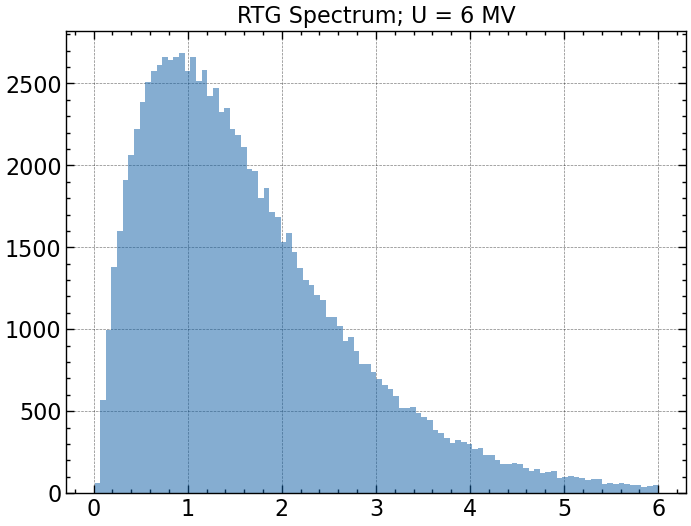

In [77]:
if beam_type == "rtg":
    Ephotons_list = simulator.Ephotons_list
    plt.hist(Ephotons_list, bins=100, alpha=0.5)
    plt.title(f"RTG Spectrum; U = {Emax} MV")


# Simulate for upper left beams
* comments

### General Simulation setup

### 1. First parameters set:
* 20x20cm
* 5x5 pixels
* monoenergetical beam
* Emono = 60 keV
* Nsim = 1e5
* beams 1 to 3 (idx 0 to 2)

In [128]:
importlib.reload(Simulator)
importlib.reload(gps)

"""
Parameters:
- spectrum_type: Type of the photon beam spectrum (e.g., "mono" for monoenergetic, "rtg" for RTG)
- Emono: Energy of the monoenergetic photons (in MeV) [if monoenergetic spectrum]
- Emax, alpha, beta: Parameters for the RTG spectrum (in MeV) [if rtg spectrum]
- LAC_tissue: Linear attenuation coefficient of the tissue (in /cm) [imported from tissue_lac_importer in advance]
- tissue_length - Length of the tissue (in cm) [we assume homogeneous tissue and square shape]
- num_pixels: Number of pixels in the detector (assumed square shape)
- Nsim: Number of simulated photons per beam

"""
# parameters
tissue_length = 20 # cm
num_pixels_x = 7
num_pixels_y = num_pixels_x
# choose spectrum type
spectrum_type = ["mono", "rtg"][1]
# number of simulated photons
Nsim = 10000



#* a) Tissue properties, pixels
tissue_box = (tissue_length, tissue_length)
if num_pixels_x % 2 == 0 or num_pixels_y % 2 == 0 or num_pixels_x != num_pixels_y:
    raise ValueError("Number of pixels in both directions must be odd and equal (square matrix)!")
tissue_shape = {}
tissue_shape["dimensions"] = tissue_box
tissue_shape["num_pixels"] = (num_pixels_x, num_pixels_y)
pixel_size = (tissue_length / num_pixels_x, tissue_length / num_pixels_y)  # z is not used in 2D
print(f"Detector shape: {tissue_box} cm")
print(f"Number of pixels: {num_pixels_x} x {num_pixels_y}")
print(f"Pixel size: {pixel_size} cm")
# simulator initialization
simulator = Simulator.box_propagation_simulator2D(
    box_dimensions = tissue_box,
    LAC_data = LAC_data_tissue,
    Emin_terminate = 0.001
)

#* b) Pencil beam characteristics
if spectrum_type == "mono":
    Emono = 0.12
    print(f"Beam type: monoenergetic; Emono={Emono}")
    lac_value = tissue_lac_importer.get_lac_at_energy(Emono)
    print(f"At {Emono} MeV, total linear attenuation coefficient is {lac_value:.4f} /cm"
            f"; (mean free path = {1/lac_value:.4f} cm)")
    pencil_beam_gps = gps.pencil_beam_gps(
        tissue_shape = tissue_shape,
        spectrum_type = spectrum_type,
        Emono = Emono,
    )
    Ebeam = f"{Emono*1000:.0f}kev"
elif spectrum_type == "rtg":
    Emax = 6 # MeV
    alpha = 1.0
    beta = 1.2
    Emean = Emax / 3
    print(f"Beam type: RTG; Emax={Emax} MeV; alpha={alpha}; beta={beta}; Emean={Emean:.2f} MeV")
    lac_value = tissue_lac_importer.get_lac_at_energy(Emean)
    print(f"At {Emean} MeV, total linear attenuation coefficient is {lac_value:.4f} /cm"
          f"; (mean free path = {1/lac_value:.4f} cm)")
    pencil_beam_gps = gps.pencil_beam_gps(
        tissue_shape = tissue_shape,
        spectrum_type = spectrum_type,
        Emax = Emean,
        alpha = alpha,
        beta = beta
    )
    Ebeam = f"{Emax:.0f}MV"


# max beam index - center (middle cell) irradiation
max_beam_index = num_pixels_y // 2
Nupper = max_beam_index + 1
print(f"Max beam index: {max_beam_index} (from 0 to {num_pixels_y - 1})")



Detector shape: (20, 20) cm
Number of pixels: 7 x 7
Pixel size: (2.857142857142857, 2.857142857142857) cm
Beam type: RTG; Emax=6 MeV; alpha=1.0; beta=1.2; Emean=2.00 MeV
At 2.0 MeV, total linear attenuation coefficient is 0.0519 /cm; (mean free path = 19.2822 cm)
Max beam index: 3 (from 0 to 6)


In [129]:
#####$ Simulation control #######
doSimulate = 1
if doSimulate == 1:
    # output mapping
    output_mapping = {"on": True}
    subfolder_name = f"./simulation_data/{spectrum_type}_{tissue_length}cm_{num_pixels_x}pixels_{Ebeam}_{Nsim:.0e}photons"
    # Create the folder if it does not exist
    if not os.path.exists(subfolder_name):
        os.makedirs(subfolder_name)
    output_mapping["folder_name"] = subfolder_name
    print(f"Output subfolder name: {output_mapping['folder_name']}")

    #* SIMULATE - loop over beam indices
    print(f"\n\nStart simulation of {spectrum_type} beams with {Nsim} photons each and energy {Emono*1000:.0e} keV\n"
          f"Tissue box dimensions: {tissue_box} cm; number of pixels: {num_pixels_x} x {num_pixels_y} (pixel size: {pixel_size} cm)"
          f"\nSimulating for beam indices up to {max_beam_index}...")
    for beam_index in range(Nupper):
        gps_template = pencil_beam_gps.get_gps_template(beam_index=beam_index)
        output_mapping["file_name"] = f"beam{beam_index}"
        # simulate photon propagation
        pp_simulation = simulator.simulate(Nsim=Nsim, SourcePhotons_template=gps_template, output_mapping=output_mapping)
else:
    print("\n\tSimulation is turned off.")

Output subfolder name: ./simulation_data/rtg_20cm_7pixels_6MV_1e+04photons


Start simulation of rtg beams with 10000 photons each and energy 1e+02 keV
Tissue box dimensions: (20, 20) cm; number of pixels: 7 x 7 (pixel size: (2.857142857142857, 2.857142857142857) cm)
Simulating for beam indices up to 3...

Starting simulation with RTG photons: U=2.0, MV; Nsim=10000

	Progress: 10.00%
	Progress: 20.00%
	Progress: 30.00%
	Progress: 40.00%
	Progress: 50.00%
	Progress: 60.00%
	Progress: 70.00%
	Progress: 80.00%
	Progress: 90.00%
------- Simulation finished -------

Starting simulation with RTG photons: U=2.0, MV; Nsim=10000

	Progress: 10.00%
	Progress: 20.00%
	Progress: 30.00%
	Progress: 40.00%
	Progress: 50.00%
	Progress: 60.00%
	Progress: 70.00%
	Progress: 80.00%
	Progress: 90.00%
------- Simulation finished -------

Starting simulation with RTG photons: U=2.0, MV; Nsim=10000

	Progress: 10.00%
	Progress: 20.00%
	Progress: 30.00%
	Progress: 40.00%
	Progress: 50.00%
	Progress: 60.00%
	Pr

# save SIF data

Foldername: rtg_20cm_7pixels_6MV_1e+04photons
Analyzing file: ./simulation_data/rtg_20cm_7pixels_6MV_1e+04photons/beam0.txt
SIF for beam index 0:
[[1.         0.8113341  0.73290486 0.58946469 0.50672937 0.41850352
  0.31913468]
 [0.01777243 0.03492644 0.05895917 0.05387542 0.05033177 0.03590834
  0.02865836]
 [0.         0.01474867 0.02167859 0.02710421 0.02722626 0.02274811
  0.02167631]
 [0.         0.         0.01453809 0.01954846 0.01531292 0.01809217
  0.01098229]
 [0.         0.         0.         0.01143751 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


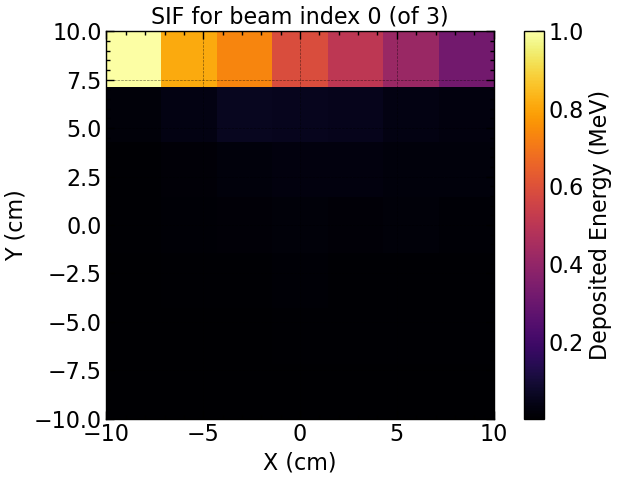

Analyzing file: ./simulation_data/rtg_20cm_7pixels_6MV_1e+04photons/beam1.txt
SIF for beam index 1:
[[0.01639666 0.03387992 0.04450508 0.05807766 0.05400629 0.04808803
  0.03438286]
 [1.         0.8501012  0.70180791 0.57894298 0.46843808 0.41342179
  0.36732063]
 [0.01902326 0.03764909 0.04945608 0.04719    0.05467276 0.03801366
  0.035502  ]
 [0.         0.02088885 0.02018258 0.02624932 0.03232405 0.02979689
  0.02286379]
 [0.         0.01043095 0.01026224 0.01368664 0.02277581 0.01342846
  0.01441259]
 [0.         0.         0.01002026 0.01097238 0.         0.01180284
  0.01111438]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


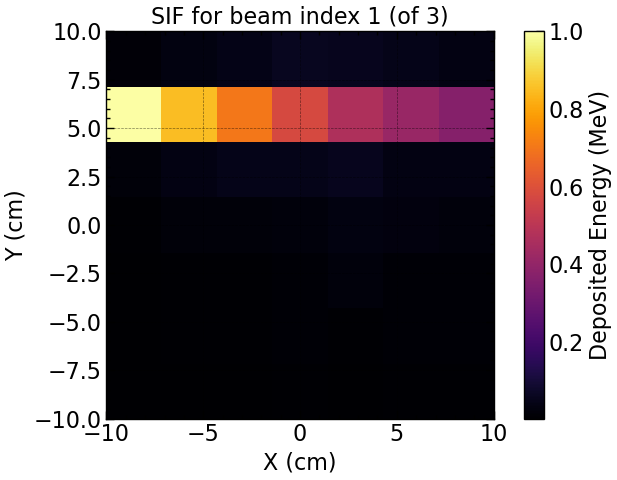

Analyzing file: ./simulation_data/rtg_20cm_7pixels_6MV_1e+04photons/beam2.txt
SIF for beam index 2:
[[0.         0.01500356 0.01797927 0.02712847 0.02683051 0.02858443
  0.02279642]
 [0.0212151  0.03216164 0.05080569 0.05144435 0.04799048 0.04508261
  0.03555775]
 [1.         0.83170088 0.68836102 0.56618252 0.49207327 0.43124536
  0.31632715]
 [0.0199047  0.03910119 0.05176168 0.04577581 0.05157845 0.04835652
  0.03474396]
 [0.         0.01655262 0.02344937 0.02202689 0.02730753 0.02746719
  0.02514152]
 [0.         0.         0.01451414 0.01703587 0.01758606 0.01739945
  0.018237  ]
 [0.         0.         0.         0.0100712  0.         0.0122293
  0.01069869]]


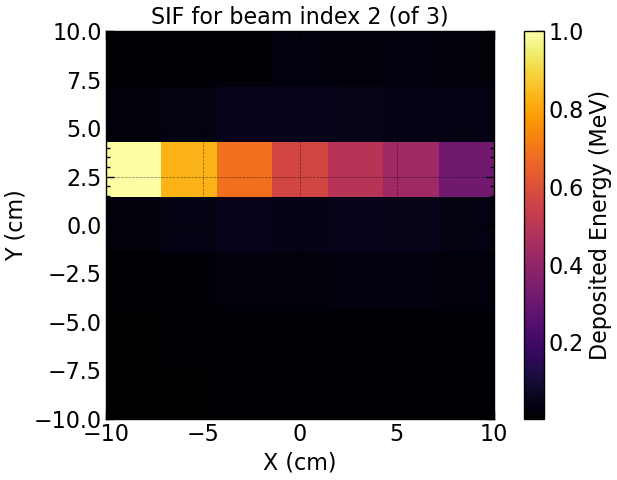

Analyzing file: ./simulation_data/rtg_20cm_7pixels_6MV_1e+04photons/beam3.txt
SIF for beam index 3:
[[0.         0.         0.01335131 0.0168569  0.01897215 0.02021644
  0.01462016]
 [0.         0.01732042 0.02368475 0.03482277 0.02881318 0.03451792
  0.02358503]
 [0.0184469  0.034131   0.05538141 0.05352929 0.05468881 0.04350068
  0.03732134]
 [1.         0.92774804 0.77241539 0.61642113 0.53948299 0.4273144
  0.34348814]
 [0.01804941 0.04092375 0.05067056 0.05349535 0.05504416 0.04301537
  0.03893141]
 [0.         0.01801758 0.02454495 0.03184007 0.02651966 0.02933328
  0.02806538]
 [0.         0.         0.01453852 0.01624647 0.0176935  0.01682462
  0.01274973]]


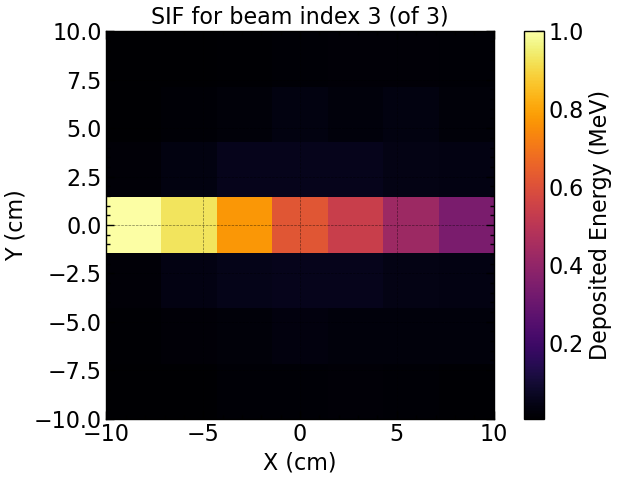

In [130]:
from src import EnergyDeposition as EDP
importlib.reload(EDP)

N = num_pixels_x
SIF_simulation = np.zeros((Nupper, N, N))
foldername = f"{spectrum_type}_{tissue_length}cm_{num_pixels_x}pixels_{Ebeam}_{Nsim:.0e}photons"
print(f"Foldername: {foldername}")

# fill the matrix
for i in range(Nupper):
    filename = f"beam{i}.txt"
    fpath = f"./simulation_data/{foldername}/{filename}"
    print(f"Analyzing file: {fpath}")
    analyzer = EDP.Edep_analyser(fpath, N,N, detector_shape=tissue_box)
    SIF_simulation[i] = analyzer.analyse()
    print(f"SIF for beam index {i}:\n{SIF_simulation[i]}")
    analyzer.plot(normalized=True, title=f"SIF for beam index {i} (of {max_beam_index})")


In [131]:
from src import BeamDataExpansion as BDE
importlib.reload(BDE)
SIF_total = BDE.expand_to_4Nbeams(SIF_simulation)


In [132]:
print(SIF_total[0])
print("\n")
print(SIF_total[7])

[[1.         0.8113341  0.73290486 0.58946469 0.50672937 0.41850352
  0.31913468]
 [0.01777243 0.03492644 0.05895917 0.05387542 0.05033177 0.03590834
  0.02865836]
 [0.         0.01474867 0.02167859 0.02710421 0.02722626 0.02274811
  0.02167631]
 [0.         0.         0.01453809 0.01954846 0.01531292 0.01809217
  0.01098229]
 [0.         0.         0.         0.01143751 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


[[0.31913468 0.41850352 0.50672937 0.58946469 0.73290486 0.8113341
  1.        ]
 [0.02865836 0.03590834 0.05033177 0.05387542 0.05895917 0.03492644
  0.01777243]
 [0.02167631 0.02274811 0.02722626 0.02710421 0.02167859 0.01474867
  0.        ]
 [0.01098229 0.01809217 0.01531292 0.01954846 0.01453809 0.
  0.        ]
 [0.         0.         0.         0.01143751 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.      

In [ ]:
sif_filename = f"SIF_{spectrum_type}_{tissue_length}cm_{num_pixels_x}pixels_{Ebeam}_{Nsim:.0e}photons"
SIF_filepath = f"../../SIF_coefficients/{sif_filename}.npy"
print(f"Saving SIF to: {SIF_filepath}")
np.save(SIF_filepath, SIF_total)


Saving SIF to: ../../SIF_coefficients/SIF_rtg_20cm_7pixels_6MV_1e+04photons.npy


---
---
---
# old

In [ ]:
# Defining parameters
####   IMPORTANT: x0 = enering loaction - change for different beam locations, shapes!
x0 = -tissue_length/2 + 10**-10

# y0
w_beam = pixel_size[0]
num_pixels = num_pixels_x 

idxmax_beam = num_pixels - 1  # Maximum index of the beam, goes from 0 to num_pixels-1
idx_beam = 0 # index of the beam, shall be between 0 and num_pixels-1
y0 = detector_shape[0] / 2 - (idx_beam + 0.5) * w_beam  # Center of the k-th pixel in y direction
print(f"Chosen beam indeks k: {idx_beam} (goes from 0 to {idxmax_beam}),")
print(f"position y0: {y0} cm (y goes from {detector_shape[0]/2} to {-detector_shape[0]/2} cm); "
      "beam position must be at the middle of chosen pixel"
      )

r0 = np.array([x0, y0, 0.0])  # Photons entering from the left side of the cuboid
u0 = np.array([1.0, 0.0, 0.0])  # Initial direction towards the positive x-axis

###################### 1. Monoenergetic photons ######################
Ephotons_mono = 0.06  # MeV, monoenergetic photon energy

SourcePhotons_template_mono = {
    'r': r0,
    'u': u0,   
    'E': Ephotons_mono,  # Initial energy of the photons in MeV
    'spectrum_type': 'mono',  # Type of the photon source spectrum
}


#*##################### 2. RTG photons ######################
#$ rtg spectrum model: 
alpha = 1.0  # Power-law exponent for the energy spectrum
beta = 1.2 # Exponential decay factor for the energy spectrum
Emax_rtg = 6  # MeV, same a U rtg tube voltage
SourcePhotons_template_rtg = {
    'r': r0,
    'u': u0,
    'Emax_rtg': Emax_rtg,  # Maximum energy of the RTG photons in MeV
    'alpha': alpha,  # Power-law exponent for the energy spectrum
    'beta': beta,  # Exponential decay factor for the energy spectrum
    'spectrum_type': 'rtg',  # Type of the photon source spectrum
}

#* choose the template for the photon source
idx_spectrum = 0 # 0 for monoenergetic, 1 for RTG
PhotonTemplate = [SourcePhotons_template_mono, SourcePhotons_template_rtg][idx_spectrum]  # Choose template 




Chosen beam indeks k: 0 (goes from 0 to 4),
position y0: 8.0 cm (y goes from 10.0 to -10.0 cm); beam position must be at the middle of chosen pixel

Number of photons to simulate: 1000


report on parameters before the siumulation
